### Baseline модель для определения именованных сущностей по кейсу от Rutube.
Поскольку нам нужно распознать нестандартные NER, можно воспользоваться помощью языковых моделей, в данном случае - Bert.
Данные вы уже получили  - это разметка, сделанная на Толоке, она не идеальна, но это часть практической задачи, с которой можно столкнуться в реальности.

Небольшое введение в NER https://habr.com/ru/companies/contentai/articles/449514/

In [1]:
!pip install razdel datasets seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 13.5 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=6764971216f6f1a95901db701beea336aaf59b37dfec0498b0cfc696058e513a
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [2]:
!pip install -U accelerate
!pip install -U transformers
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 34.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=d142044025d56979b7d51de6a71211bccbe083c806454a80ba17afc13871a0bb
  Stored in directory: /root/.cache/pip/wheels/fc/ab/

In [3]:
# считаем данные
import pandas as pd
data = pd.read_csv("ner_data_train.csv")

In [4]:
data.head(5)

,video_info,entities
0,<НАЗВАНИЕ:> Агент 117: Из Африки с любовью — Р...,"{""label"":""локация""\,""offset"":26\,""length"":6\,""..."
1,<НАЗВАНИЕ:> Коленвал Инфинити Ку икс 56= 5.6 V...,"{""label"":""организация""\,""offset"":196\,""length""..."
2,<НАЗВАНИЕ:> ВЫЗОВ ДЕМОНА = Вызвал Серого Челов...,"{""label"":""название проекта""\,""offset"":12\,""len..."
3,<НАЗВАНИЕ:> Довоенная немецкая кирха в Калинин...,"{""label"":""не найдено""\,""offset"":162\,""length"":..."
4,"<НАЗВАНИЕ:> ""Спартаку"" помогли судьи? Локомоти...","{""label"":""команда""\,""offset"":13\,""length"":8\,""..."


In [5]:
# данные спарсены с Толоки, поэтому могут иметь проблемы с символами и их нужно избежать,
# удалить лишние '\' например, преобразовать из str в список dict-ов
import json
df = data.copy()
df['entities'] = df['entities'].apply(lambda l: l.replace('\,', ',')if isinstance(l, str) else l)
df['entities'] = df['entities'].apply(lambda l: l.replace('\\\\', '\\')if isinstance(l, str) else l)
df['entities'] = df['entities'].apply(lambda l: '[' + l + ']'if isinstance(l, str) else l)
df['entities'] = df['entities'].apply(lambda l: json.loads(l)if isinstance(l, str) else l)

In [6]:
df.head(3)

,video_info,entities
0,<НАЗВАНИЕ:> Агент 117: Из Африки с любовью — Р...,"[{'label': 'локация', 'offset': 26, 'length': ..."
1,<НАЗВАНИЕ:> Коленвал Инфинити Ку икс 56= 5.6 V...,"[{'label': 'организация', 'offset': 196, 'leng..."
2,<НАЗВАНИЕ:> ВЫЗОВ ДЕМОНА = Вызвал Серого Челов...,"[{'label': 'название проекта', 'offset': 12, '..."


#### Оригинал туториала на медицинских данных можно посмотреть тут https://gist.github.com/avidale/cacf235aebeaaf4c578389e1146c3c57

In [7]:
# Теперь из наших данных нам нужно извлечь для каждого слова (токена) его тег (label) из разметки, чтобы потом предать в модель классификации токенов
from razdel import tokenize

def extract_labels(item):

    # воспользуемся удобным токенайзером из библиотеки razdel,
    # она помимо разбиения на слова, сохраняет важные для нас числа - начало и конец слова в токенах

    raw_toks = list(tokenize(item['video_info']))
    words = [tok.text for tok in raw_toks]
    # присвоим для начала каждому слову тег 'О' - тег, означающий отсутствие NER-а
    word_labels = ['O'] * len(raw_toks)
    char2word = [None] * len(item['video_info'])
    # так как NER можем состаять из нескольких слов, то нам нужно сохранить эту инфорцию
    for i, word in enumerate(raw_toks):
        char2word[word.start:word.stop] = [i] * len(word.text)

    labels = item['entities']
    if isinstance(labels, dict):
        labels = [labels]
    if labels is not None:
        for e in labels:
            if e['label'] != 'не найдено':
                e_words = sorted({idx for idx in char2word[e['offset']:e['offset']+e['length']] if idx is not None})
                if e_words:
                    word_labels[e_words[0]] = 'B-' + e['label']
                    for idx in e_words[1:]:
                        word_labels[idx] = 'I-' + e['label']
                else:
                    continue
            else:
                continue
        return {'tokens': words, 'tags': word_labels}
    else: return {'tokens': words, 'tags': word_labels}

In [8]:
print(extract_labels(df.iloc[0]))

{'tokens': ['<', 'НАЗВАНИЕ', ':', '>', 'Агент', '117', ':', 'Из', 'Африки', 'с', 'любовью', '—', 'Русский', 'тизер', '=', 'трейлер', '(', '2021', ')', '<', 'ОПИСАНИЕ', ':', '>', 'Лучший', 'Telegram', 'канал', 'о', 'кино', '<', 'LINK', '>', 'Сотрудничество', '<', 'LINK', '>', 'Дата', 'выхода', '26', 'августа', '2021', 'Оригинальное', 'название', ':', 'OSS', '117', ':', 'Alerte', 'rouge', 'en', 'Afrique', 'noire', 'Страна', ':', 'Франция', 'Режиссер', ':', 'Николя', 'Бедос', 'Жанр', ':', 'боевик', ',', 'комедия', 'В', 'главных', 'ролях', ':', 'Жан', 'Дюжарден', ',', 'Пьер', 'Нинэ', ',', 'Мелоди', 'Каста', ',', 'Наташа', 'Линдинжер', ',', 'Владимир', 'Иорданов', ',', 'Фату', 'Н', '’', 'Диайе', ',', 'Пол', 'Уайт', 'Мир', 'изменился', '.', 'Он', 'нет', '.', 'Судьба', 'заносит', 'легендарного', 'Агента', '117', 'в', 'Африку', ',', 'где', 'горячее', 'пустыни', 'только', 'женщины', '.', 'Вооруженный', 'неиссякаемой', 'уверенностью', 'в', 'себе', 'и', 'убийственной', 'харизмой', ',', 'он', 'мож

### Обработаем датасет и разобьем на трейн и тест

In [9]:
from sklearn.model_selection import train_test_split
ner_data = [extract_labels(item) for i, item in df.iterrows()]

In [10]:
import nltk
from nltk.corpus import stopwords
import pymorphy2
import re

nltk.download('stopwords')
stopwords_ru = stopwords.words("russian")
morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
def prepare_learning_data(dataset):
  tokens = []
  tags = []
  ids = []
  for i, item in dataset.iterrows():
    new_token = []
    new_tag = []
    new_id = []

    for id, row in enumerate(zip(item['tokens'], item['tags'])):
      token = row[0]
      tag = row[1]
      if token not in stopwords_ru and re.match(r'^[А-Яа-яa-zA-Z0-9:’]+$', token) is not None:
        new_token.append(morph.normal_forms(token.lower())[0])
        new_tag.append(tag)
        new_id.append(id)

    tokens.append(new_token)
    tags.append(new_tag)
    ids.append(new_id)

  return pd.DataFrame({'tokens':tokens, 'tags':tags, 'ids':ids})

def prepare_test_data(dataset):
  tokens = []
  ids = []
  for i, item in dataset.iterrows():
    new_token = []
    new_id = []

    for id, token in enumerate(item['tokens']):
      if (token not in stopwords_ru and re.match(r'^[А-Яа-яa-zA-Z0-9:’]+$', token) is not None):
        new_token.append(morph.normal_forms(token.lower())[0])
        new_id.append(id)

    tokens.append(new_token)
    ids.append(new_id)

  return pd.DataFrame({'tokens':tokens, 'ids':ids})


def get_old(dataset):
  olds = []
  for _, item in dataset.iterrows():
    old = ['O'] * (item['ids'][-1] + 1)
    for i in range(len(item['ids'])):
      old[item['ids'][i]] = item['tags'][i]
    olds.append(old)
  return pd.DataFrame({'tags':olds})

In [12]:
input_df = pd.DataFrame(ner_data)

fixed_df = prepare_learning_data(input_df.head(1))

old_df = get_old(fixed_df)
ln = len(old_df['tags'][0])

print(input_df.head(1)['tags'][0][:ln] == old_df['tags'][0])

# test = pd.DataFrame({'t1':input_df.head(1)['tags'][0][:ln], 't2':old_df['tags'][0]})
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(test)


test_input_df = pd.DataFrame({'tokens': [input_df['tokens'][0]]})

test_fixed_df = prepare_test_data(test_input_df)





True


In [13]:
input_df = pd.DataFrame(ner_data)

import time

start = time.time()

fixed_df = prepare_learning_data(input_df)

print(time.time() - start)



98.39723634719849


In [14]:
new_ner_data = {'tokens': fixed_df['tokens'].values, 'tags': fixed_df['tags'].values}
ner_train, ner_test = train_test_split(ner_data, test_size=0.2, random_state=1)

#### Посмотрим на получившиеся теги
Подробнее почитать про BIO теги можно тут https://datascience.stackexchange.com/questions/63399/what-is-bio-tags-for-creating-custom-ner-named-entity-recognization

In [15]:
label_list = sorted({label for item in ner_train for label in item['tags']})
if 'O' in label_list:
    label_list.remove('O')
    label_list = ['O'] + label_list
label_list

['O',
 'B-Дата',
 'B-бренд',
 'B-вид спорта',
 'B-видеоигра',
 'B-команда',
 'B-лига',
 'B-локация',
 'B-модель',
 'B-название проекта',
 'B-организация',
 'B-персона',
 'B-сезон',
 'B-серия',
 'I-Дата',
 'I-бренд',
 'I-вид спорта',
 'I-видеоигра',
 'I-команда',
 'I-лига',
 'I-локация',
 'I-модель',
 'I-название проекта',
 'I-организация',
 'I-персона',
 'I-сезон',
 'I-серия']

In [16]:
from datasets import Dataset, DatasetDict

In [17]:
ner_data = DatasetDict({
    'train': Dataset.from_pandas(pd.DataFrame(ner_train)),
    'test': Dataset.from_pandas(pd.DataFrame(ner_test))
})
ner_data

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 5137
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 1285
    })
})

### Запустим модель RuBert-tiny - классический Bert, поверх которого навешен слой классификации токенов.

In [38]:
from transformers import AutoTokenizer
from datasets import load_dataset, load_metric

model_checkpoint = "papluca/xlm-roberta-base-language-detection"
batch_size = 1

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, device='gpu')

In [39]:
example = ner_train[5]
print(example["tokens"])

['<', 'НАЗВАНИЕ', ':', '>', 'Московский', 'международный', 'фестиваль', 'мира', '=', '89', 'и', 'Стас', 'Намин', '.', '«', 'Главный', 'день', '»', '<', 'ОПИСАНИЕ', ':', '>', '12', 'и', '13', 'июня', '1989', 'года', 'на', 'Центральном', 'стадионе', 'имени', 'В', '.', 'И', '.', 'Ленина', 'состоялся', 'первый', 'международный', 'рок', 'фестиваль', '.', 'Концерт', 'собрал', 'свыше', '100', 'тысяч', 'зрителей', '.', 'Советская', 'молодежь', 'тогда', 'увидела', 'и', 'услышала', 'признанных', 'мировых', 'кумиров', ':', 'Scorpions', ',', 'Bon', 'Jovi', ',', 'Ozzy', 'Osbourne', ',', 'Cinderella', ',', 'Motley', 'Crue', '.', 'Приезд', 'западных', 'звезд', 'казался', 'ожившей', 'фантастикой', '.', 'Фестиваль', 'стал', 'не', 'только', 'музыкальной', ',', 'но', 'и', 'важной', 'политической', 'акцией', '.', 'Вся', 'мировая', 'пресса', 'писала', 'о', 'том', ',', 'что', 'СССР', 'и', 'США', ',', 'долгое', 'время', 'находившиеся', 'в', 'состоянии', '"', 'холодной', 'войны', '"', ',', 'наконец', 'то', 'с

In [40]:
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
print(tokens)

['<s>', '▁<', '▁НА', 'З', 'ВА', 'НИЕ', '▁:', '▁>', '▁Московск', 'ий', '▁между', 'народ', 'ный', '▁фестиваль', '▁мира', '▁=', '▁89', '▁и', '▁Ста', 'с', '▁На', 'мин', '▁', '.', '▁«', '▁Глав', 'ный', '▁день', '▁»', '▁<', '▁О', 'ПИС', 'А', 'НИЕ', '▁:', '▁>', '▁12', '▁и', '▁13', '▁июня', '▁1989', '▁года', '▁на', '▁Центральн', 'ом', '▁стадион', 'е', '▁имени', '▁В', '▁', '.', '▁И', '▁', '.', '▁Ленин', 'а', '▁состоя', 'лся', '▁первый', '▁между', 'народ', 'ный', '▁рок', '▁фестиваль', '▁', '.', '▁Концерт', '▁со', 'брал', '▁свыше', '▁100', '▁тысяч', '▁зрител', 'ей', '▁', '.', '▁Совет', 'ская', '▁молод', 'еж', 'ь', '▁тогда', '▁увидел', 'а', '▁и', '▁услышал', 'а', '▁призна', 'нных', '▁мир', 'овых', '▁ку', 'мир', 'ов', '▁:', '▁S', 'corp', 'ions', '▁', ',', '▁Bon', '▁Jo', 'vi', '▁', ',', '▁O', 'zzy', '▁Os', 'bour', 'ne', '▁', ',', '▁C', 'inde', 'rella', '▁', ',', '▁Mot', 'ley', '▁Cru', 'e', '▁', '.', '▁При', 'езд', '▁запад', 'ных', '▁звезд', '▁каза', 'лся', '▁ожи', 'вшей', '▁фантасти', 'кой', '▁', '.

In [41]:
len(example["tags"]), len(tokenized_input["input_ids"])

(170, 276)

In [42]:
print(tokenized_input.word_ids())

[None, 0, 1, 1, 1, 1, 2, 3, 4, 4, 5, 5, 5, 6, 7, 8, 9, 10, 11, 11, 12, 12, 13, 13, 14, 15, 15, 16, 17, 18, 19, 19, 19, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 29, 30, 30, 31, 32, 33, 33, 34, 35, 35, 36, 36, 37, 37, 38, 39, 39, 39, 40, 41, 42, 42, 43, 44, 44, 45, 46, 47, 48, 48, 49, 49, 50, 50, 51, 51, 51, 52, 53, 53, 54, 55, 55, 56, 56, 57, 57, 58, 58, 58, 59, 60, 60, 60, 61, 61, 62, 63, 63, 64, 64, 65, 65, 66, 66, 66, 67, 67, 68, 68, 68, 69, 69, 70, 70, 71, 71, 72, 72, 73, 73, 74, 74, 75, 76, 76, 77, 77, 78, 78, 79, 79, 80, 80, 81, 82, 83, 84, 84, 85, 85, 86, 87, 88, 88, 89, 90, 90, 91, 91, 92, 92, 93, 93, 94, 94, 95, 95, 96, 97, 98, 98, 99, 100, 101, 102, 103, 103, 104, 104, 105, 106, 106, 107, 108, 109, 110, 110, 111, 112, 113, 113, 114, 115, 116, 117, 117, 117, 118, 118, 118, 118, 119, 120, 121, 121, 122, 122, 123, 123, 124, 124, 125, 125, 126, 126, 127, 127, 128, 128, 128, 129, 130, 130, 131, 132, 132, 133, 133, 134, 134, 135, 136, 137, 137, 138, 139, 139, 140, 141, 141, 142, 

In [43]:
word_ids = tokenized_input.word_ids()
aligned_labels = [-100 if i is None else example["tags"][i] for i in word_ids]
print(len(aligned_labels), len(tokenized_input["input_ids"]))

276 276


#### У Bert свой собсвенный токенайзер, который разбивает слова на мелкие токены, поэтому нам нужно корректно сопоставить токены и соответсвующие им неры.

In [44]:
def tokenize_and_align_labels(examples, label_all_tokens=True):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples['tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        label_ids = [label_list.index(idx) if isinstance(idx, str) else idx for idx in label_ids]

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [45]:
tokenize_and_align_labels(ner_data['train'][1:2])

{'input_ids': [[0, 4426, 5315, 4026, 29889, 189182, 152, 977, 51208, 75586, 54039, 6, 83389, 45799, 1270, 102356, 4426, 1089, 157933, 1709, 189182, 152, 977, 123811, 336, 10698, 4558, 8568, 111529, 89, 69361, 19776, 100347, 292, 51208, 75586, 54039, 6, 83389, 45799, 1270, 102356, 6, 5, 417, 3920, 8165, 47745, 90216, 10041, 13549, 4476, 6, 5, 1089, 25358, 98590, 35, 98465, 100347, 1214, 129, 49571, 546, 135, 170769, 146408, 131567, 6, 47871, 1435, 8113, 1560, 8568, 129, 184862, 312, 1089, 88691, 89, 93362, 419, 93834, 17968, 63781, 6, 5, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 2

In [46]:
tokenized_datasets = ner_data.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/5137 [00:00<?, ? examples/s]

Map:   0%|          | 0/1285 [00:00<?, ? examples/s]

#### Сохраняем словарик соотвествия тега и его индекса внутри модели

In [47]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list),ignore_mismatched_sizes=True)
model.config.id2label = dict(enumerate(label_list))
model.config.label2id = {v: k for k, v in model.config.id2label.items()}

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at papluca/xlm-roberta-base-language-detection and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
# Специальный объект для удобного формирования батчей
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

In [49]:
model

XLMRobertaForTokenClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bi

### В качестве метрик возьмем precision, recall, accuracy, для этого воспользуемся специализированной под Ner задачу библиотеку seqeval

In [50]:
metric = load_metric("seqeval")

In [51]:
example = ner_train[4]
labels = example['tags']
metric.compute(predictions=[labels], references=[labels])

{'бренд': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'локация': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

In [52]:
args = TrainingArguments(
    "ner",
    evaluation_strategy = "epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=20,
    weight_decay=0.01,
    save_strategy='no',
    report_to='none',
)

In [53]:
import logging
from transformers.trainer import logger as noisy_logger
noisy_logger.setLevel(logging.WARNING)

In [54]:
# Для дообучения берта можно эксперементировать с заморозкой/разморозкой разных слоев, здесь мы оставим все слои размороженными
# Для быстроты обучения можно заморозить всю бертовую часть, кроме классификатора, но тогда качесвто будет похуже
for param in model.parameters():
    param.requires_grad = True

In [55]:
import numpy as np

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels, zero_division=0)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [56]:
args = TrainingArguments(
    "ner",
    evaluation_strategy = "epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=0.01,
    save_strategy='no',
    report_to='none',
)

In [57]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [58]:
trainer.train()

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.326900,0.332967,0.541036,0.508982,0.524520,0.909130
2,0.300400,0.334932,0.549562,0.553008,0.551280,0.912809
3,0.279800,0.363130,0.542606,0.592723,0.566558,0.911987
4,0.232300,0.385387,0.544238,0.563329,0.553619,0.910688
5,0.198100,0.432387,0.529799,0.588216,0.557482,0.909384
6,0.162200,0.476404,0.540128,0.589523,0.563745,0.909883
7,0.145000,0.542353,0.511970,0.620223,0.560922,0.906920
8,0.088400,0.590193,0.535967,0.583056,0.558521,0.909718
9,0.111700,0.602687,0.532863,0.577765,0.554406,0.908071
10,0.074600,0.632472,0.533357,0.579136,0.555305,0.908461


TrainOutput(global_step=51370, training_loss=0.20262603863728565, metrics={'train_runtime': 8485.9226, 'train_samples_per_second': 6.054, 'train_steps_per_second': 6.054, 'total_flos': 4898568576901860.0, 'train_loss': 0.20262603863728565, 'epoch': 10.0})

In [59]:
trainer.evaluate()

{'eval_loss': 0.6324723362922668,
 'eval_precision': 0.5333573963785117,
 'eval_recall': 0.5791364556796655,
 'eval_f1': 0.5553050231742453,
 'eval_accuracy': 0.9084608708537076,
 'eval_runtime': 30.2674,
 'eval_samples_per_second': 42.455,
 'eval_steps_per_second': 42.455,
 'epoch': 10.0}

In [78]:
# Посчитаем метрики на отложенном датасете

predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
results

{'Дата': {'precision': 0.5584768812330009,
  'recall': 0.646379853095488,
  'f1': 0.5992217898832685,
  'number': 953},
 'бренд': {'precision': 0.4212962962962963,
  'recall': 0.38342696629213485,
  'f1': 0.40147058823529413,
  'number': 712},
 'вид спорта': {'precision': 0.4,
  'recall': 0.3925233644859813,
  'f1': 0.39622641509433965,
  'number': 214},
 'видеоигра': {'precision': 0.4654002713704206,
  'recall': 0.5236641221374045,
  'f1': 0.492816091954023,
  'number': 655},
 'команда': {'precision': 0.4572192513368984,
  'recall': 0.4476439790575916,
  'f1': 0.4523809523809524,
  'number': 382},
 'лига': {'precision': 0.26523297491039427,
  'recall': 0.4868421052631579,
  'f1': 0.3433874709976798,
  'number': 152},
 'локация': {'precision': 0.5699208443271768,
  'recall': 0.6447761194029851,
  'f1': 0.6050420168067228,
  'number': 2680},
 'модель': {'precision': 0.2725563909774436,
  'recall': 0.3419811320754717,
  'f1': 0.303347280334728,
  'number': 424},
 'название проекта': {'pr

In [63]:
! pip install scikit-plot

In [79]:
import scikitplot as skplt

In [92]:
pred = []
for i in range(len(true_predictions)):
  for j in range(len(true_predictions[i])):
    if true_labels[i][j] != 'O':
      pred.append(true_predictions[i][j])

In [93]:
labels = []
for i in true_labels:
  for j in i:
    if j != 'O':
      labels.append(j)

In [82]:
import matplotlib.pyplot as plt

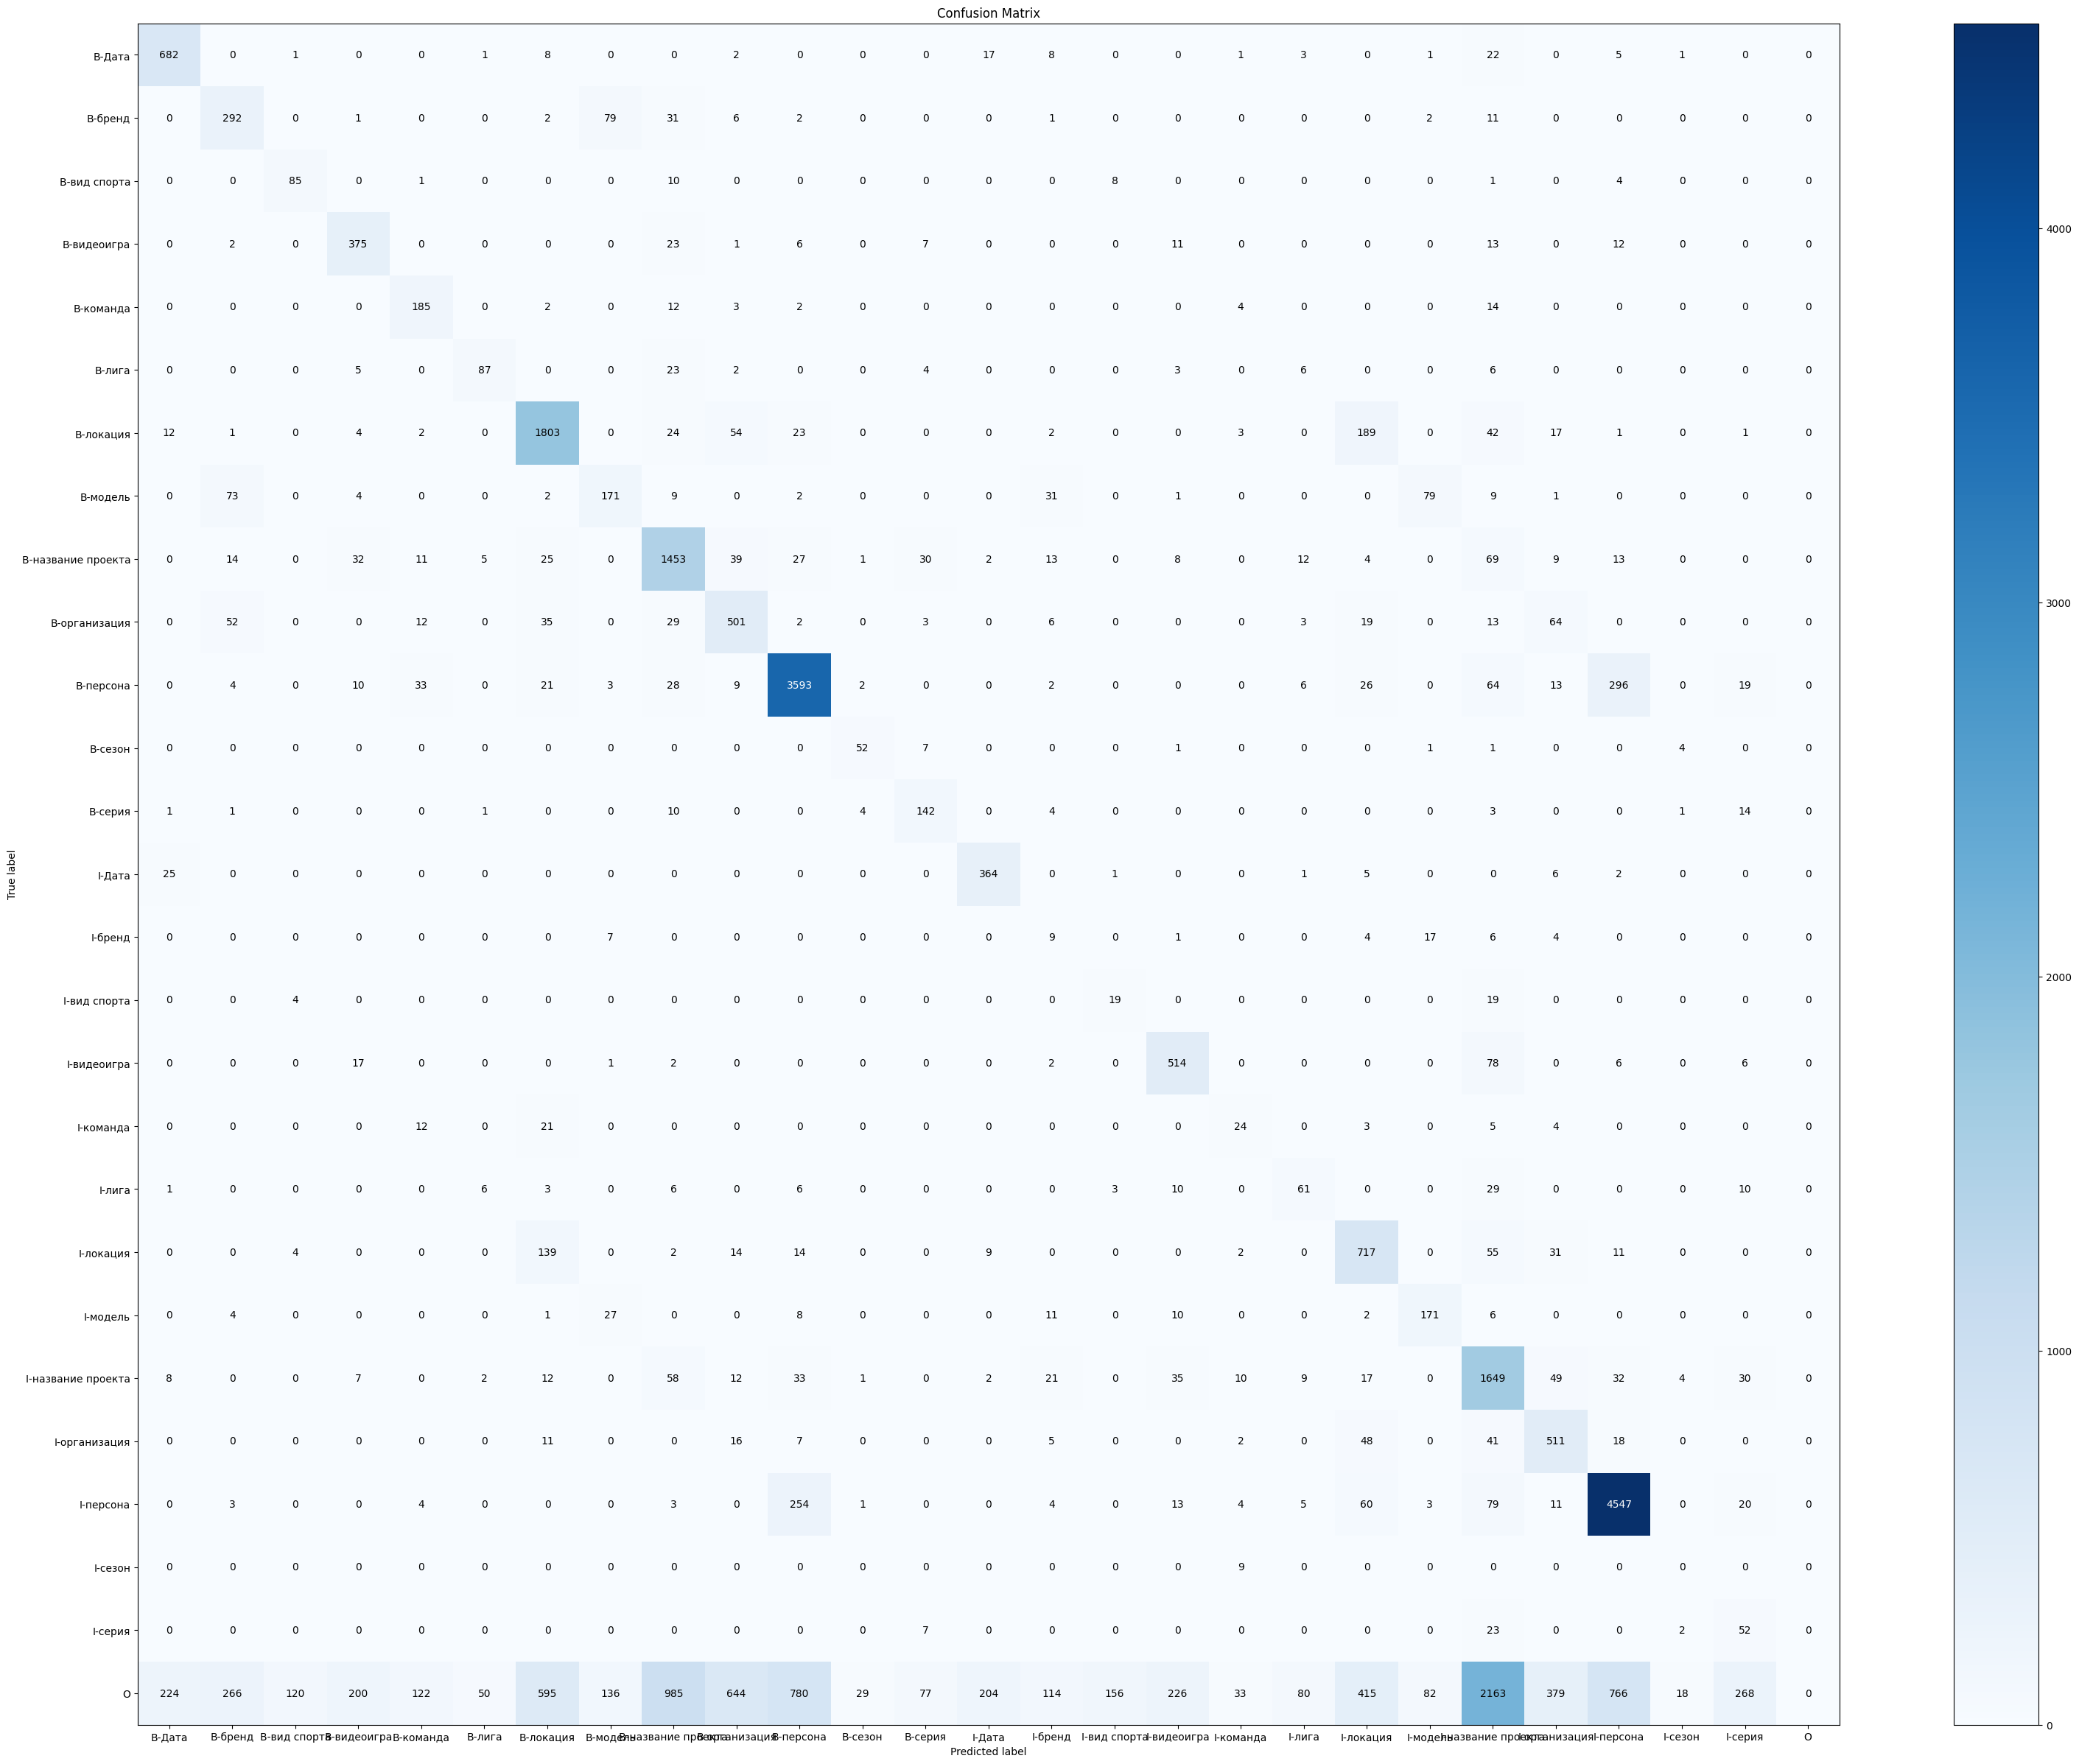

In [97]:
skplt.metrics.plot_confusion_matrix(pred, labels, normalize=False, figsize=(40,30))
plt.show()

In [66]:
from sklearn.metrics import confusion_matrix
import pandas as pd

In [98]:
cm = pd.DataFrame(
    confusion_matrix(sum(true_labels, []), sum(true_predictions, []), labels=label_list),
    index=label_list,
    columns=label_list
)
cm

,O,B-Дата,B-бренд,B-вид спорта,B-видеоигра,B-команда,B-лига,B-локация,B-модель,B-название проекта,...,I-видеоигра,I-команда,I-лига,I-локация,I-модель,I-название проекта,I-организация,I-персона,I-сезон,I-серия
O,196524,303,201,93,246,148,137,806,131,935,...,430,50,102,484,136,1156,441,972,18,31
B-Дата,224,682,0,0,0,0,0,12,0,0,...,0,0,1,0,0,8,0,0,0,0
B-бренд,266,0,292,0,2,0,0,1,73,14,...,0,0,0,0,4,0,0,3,0,0
B-вид спорта,120,1,0,85,0,0,0,0,0,0,...,0,0,0,4,0,0,0,0,0,0
B-видеоигра,200,0,1,0,375,0,5,4,4,32,...,17,0,0,0,0,7,0,0,0,0
B-команда,122,0,0,1,0,185,0,2,0,11,...,0,12,0,0,0,0,0,4,0,0
B-лига,50,1,0,0,0,0,87,0,0,5,...,0,0,6,0,0,2,0,0,0,0
B-локация,595,8,2,0,0,2,0,1803,2,25,...,0,21,3,139,1,12,11,0,0,0
B-модель,136,0,79,0,0,0,0,0,171,0,...,1,0,0,0,27,0,0,0,0,0
B-название проекта,985,0,31,10,23,12,23,24,9,1453,...,2,0,6,2,0,58,0,3,0,0


In [68]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [69]:
model.save_pretrained('/content/drive/MyDrive/ner_bert.bin')
tokenizer.save_pretrained('/content/drive/MyDrive/ner_bert.bin')

('/content/drive/MyDrive/ner_bert.bin/tokenizer_config.json',
 '/content/drive/MyDrive/ner_bert.bin/special_tokens_map.json',
 '/content/drive/MyDrive/ner_bert.bin/tokenizer.json')

### Посмотрим на результаты

In [ ]:
# text = ' '.join(ner_train[25]['tokens'])
text = ner_train[25]['tokens']

In [ ]:
import torch
from transformers import pipeline

pipe = pipeline(model=model, tokenizer=tokenizer, task='ner', aggregation_strategy='average', device='cpu')

def predict_ner(text, tokenizer, model, pipe, verbose=True):
    tokens = tokenizer(text, truncation=True, is_split_into_words=True, return_tensors='pt')
    tokens = {k: v.to(model.device) for k, v in tokens.items()}

    with torch.no_grad():
        pred = model(**tokens)
    # print(pred.logits.shape)
    indices = pred.logits.argmax(dim=-1)[0].cpu().numpy()
    token_text = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])
    labels = []
    for t, idx in zip(token_text, indices):
        if '##' not in t:
            labels.append(label_list[idx])
        if verbose:
            print(f'{t:15s} {label_list[idx]:10s}')
    return text, pipe(text), labels

In [ ]:
predict_ner(text, tokenizer, model, pipe)

### Тестового датасета у вас пока нет, по которому будет считаться метрика на лидерборде, но прогоним для примера через нашу отложенную выборку, чтобы понять формат выходных данных.
ВАЖНО: в тестовом датасете у вас будет тест в том же формате, что он был в трейне 'video_info', в финальном сабмишене эту колонку и индексы менять нельзя, нужно будет только заполнить колонку 'entities_prediction'

In [ ]:
from tqdm.notebook import tqdm

submission = pd.DataFrame(columns=[['video_info', 'entities_prediction']])
submission['entities_prediction'] = submission['entities_prediction'].astype('object')
def sample_submission(text, tokenizer, model, pipe, submission):
    for i, elem in tqdm(enumerate(ner_test)):
        _, _, labels = predict_ner(elem['tokens'], tokenizer, model, pipe, verbose=False)
        submission.loc[i, 'video_info'] = elem

        submission.loc[i, 'entities_prediction'] = [[label] for label in labels]
    return submission

In [ ]:
result = sample_submission(text, tokenizer, model, pipe, submission)

In [ ]:
result

In [ ]:
len(ner_test)